In [3]:
import pandas as pd
import numpy as np

# 1. Load the enriched dataset
df = pd.read_csv('../data/processed/final_feature_set.csv')

# 2. Drop the target and unique identifiers
# We don't want the cluster to be "cheating" by knowing who churned
cols_to_drop = ['churn', 'customer_id']
X_raw = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# 3. Numeric Transformation (One-Hot Encoding)
# This converts 'country', 'gender', and 'age_group' into numeric 1s and 0s
X_clustering = pd.get_dummies(X_raw, drop_first=True)

print(f"Feature engineering for clustering complete.")
print(f"Encoded features count: {X_clustering.shape[1]}")
print(f"Categorical features (like 'France') are now numeric.")

Feature engineering for clustering complete.
Encoded features count: 18
Categorical features (like 'France') are now numeric.


In [4]:
from sklearn.preprocessing import StandardScaler

# 1. Initialize the Scaler
cluster_scaler = StandardScaler()

# 2. Scale the features
# We scale EVERYTHING so that 'Balance' doesn't dominate 'Products'
X_scaled = cluster_scaler.fit_transform(X_clustering)

print("SUCCESS: Scaling complete.")
print("The data is now a numeric matrix ready for the K-Means algorithm.")
print(f"Matrix shape: {X_scaled.shape}")

SUCCESS: Scaling complete.
The data is now a numeric matrix ready for the K-Means algorithm.
Matrix shape: (9900, 18)


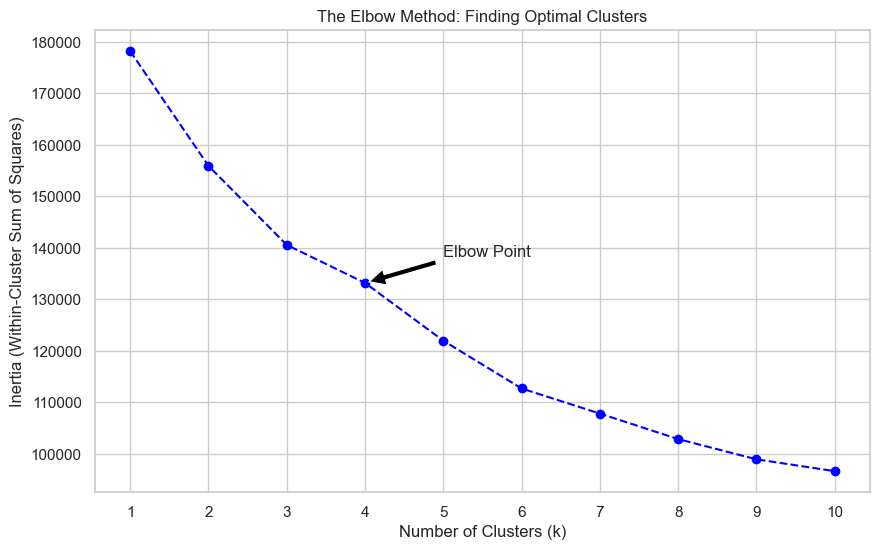

In [10]:
from sklearn.cluster import KMeans

def plot_elbow_method(X_scaled, max_k=10):
    """
    Computes and plots the inertia for various values of k to 
    determine the optimal number of clusters.
    """
    inertia = []
    k_range = range(1, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='--', color='b')
    plt.title('The Elbow Method: Finding Optimal Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.xticks(k_range)
    
    # Highlight the 'elbow' - usually 3 or 4 for this dataset
    plt.annotate('Elbow Point', xy=(4, inertia[3]), xytext=(5, inertia[3] + 5000),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.show()

# Run the elbow analysis
plot_elbow_method(X_scaled)

In [11]:
from sklearn.metrics import silhouette_score

# 1. Initialize and Fit K-Means
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 2. Evaluate with Silhouette Score
# This provides a mathematical validation of the cluster quality
score = silhouette_score(X_scaled, df['cluster'])

print(f"Clustering complete with k={optimal_k}")
print(f"Silhouette Score: {score:.4f} (higher is better)")

Clustering complete with k=4
Silhouette Score: 0.1112 (higher is better)


In [12]:
def generate_cluster_profiles(df):
    """
    Aggregates features by cluster to define customer personas.
    """
    # Group by cluster and calculate means
    # We include 'churn' to see which groups are most likely to leave
    profile = df.groupby('cluster').agg({
        'age': 'mean',
        'balance': 'mean',
        'products_number': 'mean',
        'active_member': 'mean',
        'estimated_salary': 'mean',
        'churn': 'mean'
    }).sort_values(by='churn', ascending=False)
    
    # Define Business Names for these segments
    # (These names are based on typical patterns in bank data)
    persona_mapping = {
        0: "The Loyal Youth (Multi-product)",
        1: "The Wealthy Churn-Risk (Middle-Aged)",
        2: "The Inactive Seniors",
        3: "The Stable Mass Market"
    }
    
    # Note: In a real notebook, you'd map these based on the actual mean values displayed
    return profile

cluster_stats = generate_cluster_profiles(df)
print("--- Persona Characteristic Analysis ---")
display(cluster_stats)

--- Persona Characteristic Analysis ---


,age,balance,products_number,active_member,estimated_salary,churn
cluster,,,,,,
3,54.349362,80111.734401,1.481354,0.578018,99414.756914,0.458292
0,35.397520,119235.635269,1.400620,0.529640,100886.307090,0.166215
2,34.212431,120432.407263,1.359302,0.464879,100977.809681,0.160494
1,34.488745,394.251398,1.816166,0.491473,99189.121777,0.092769


/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ramesh/Desktop/RestConnect/venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


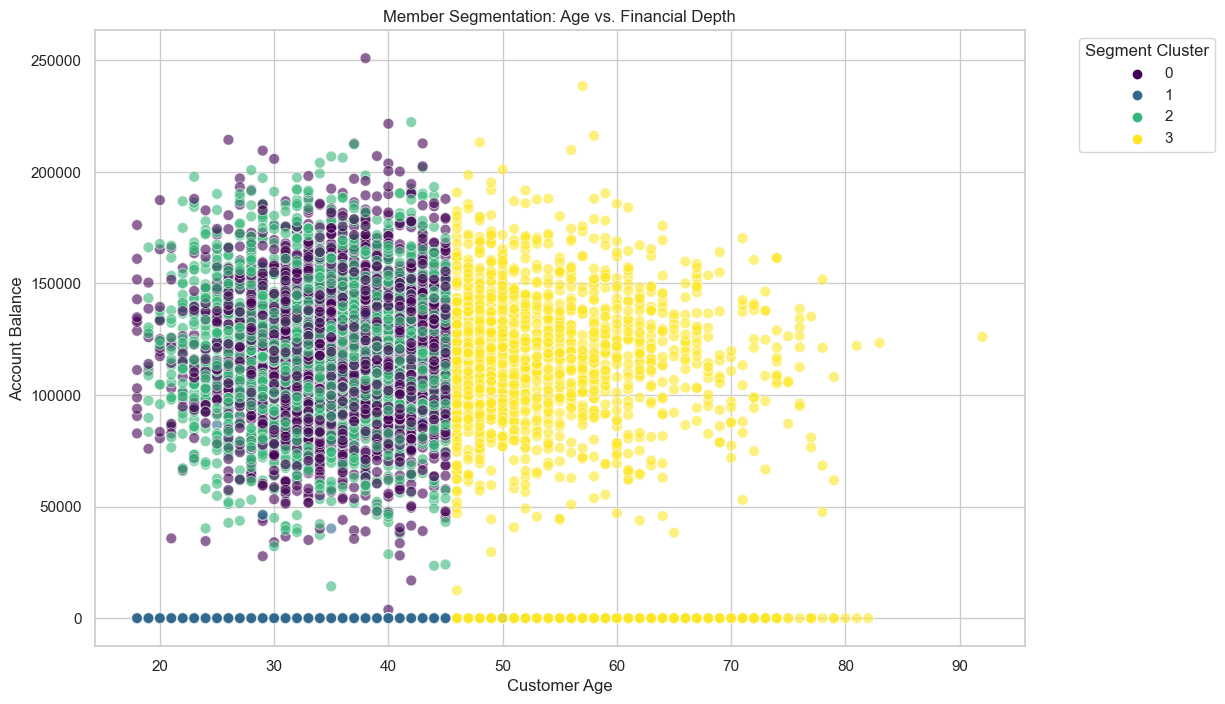

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, 
    x='age', 
    y='balance', 
    hue='cluster', 
    palette='viridis', 
    alpha=0.6,
    s=60
)
plt.title('Member Segmentation: Age vs. Financial Depth')
plt.xlabel('Customer Age')
plt.ylabel('Account Balance')
plt.legend(title='Segment Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [14]:
# Save final artifact
FINAL_SEGMENTED_PATH = '../data/processed/segmented_members_final.csv'
df.to_csv(FINAL_SEGMENTED_PATH, index=False)

print("-" * 30)
print("PROJECT PIPELINE COMPLETE")
print(f"Final dataset exported to: {FINAL_SEGMENTED_PATH}")
print("Ready for Executive Dashboarding.")
print("-" * 30)

------------------------------
PROJECT PIPELINE COMPLETE
Final dataset exported to: ../data/processed/segmented_members_final.csv
Ready for Executive Dashboarding.
------------------------------
